In [1]:
%load_ext autoreload
%autoreload 2

import squidpy as sq
from skimage import io
import scanpy as sc
import time
import os

In [2]:
from napari_sparrow import functions as fc

In [3]:
# Path prefix for the data folder, use variable from .env file or default
DATA_PATH_PREFIX = os.getenv("DATA_PATH_PREFIX", default="../data")
SMALL_IMAGE = os.getenv("SMALL_IMAGE", default="False") in ["True", "true", "t"]
DEVICE = os.getenv("DEVICE", default="cuda:4")

name_slide = "A1-1"
path_coordinates = (
    DATA_PATH_PREFIX + "/resolve_liver/20272_slide1_" + name_slide + "_results.txt"
)
path_image = (
    DATA_PATH_PREFIX + "/resolve_liver/20272_slide1_" + name_slide + "_DAPI.tiff"
)

img = io.imread(path_image)
ic = sq.im.ImageContainer(img)

INFO:basicpy.basicpy:Initializing BaSiC 139854743942720 with parameters: 
epsilon: 1e-06

INFO:basicpy.basicpy:=== BaSiC fit started ===
INFO:basicpy.basicpy:reweighting iteration 0
INFO:basicpy.basicpy:single-step optimization score: 7.006038913459633e-07.
INFO:basicpy.basicpy:mean of S: 1.0.
INFO:basicpy.basicpy:Iteration 0 finished.
INFO:basicpy.basicpy:reweighting iteration 1
INFO:basicpy.basicpy:single-step optimization score: 2.825247520377161e-06.
INFO:basicpy.basicpy:mean of S: 0.9999999403953552.
INFO:basicpy.basicpy:Iteration 1 finished.
INFO:basicpy.basicpy:reweighting score: 0.007602143567055464
INFO:basicpy.basicpy:elapsed time: 7.096357950940728 seconds
INFO:basicpy.basicpy:Reweighting converged.
INFO:basicpy.basicpy:=== BaSiC fit finished in 8.186269026249647 seconds ===
INFO:basicpy.basicpy:=== BaSiC transform started ===
INFO:basicpy.basicpy:=== BaSiC transform finished in 1.522436773404479 seconds ===


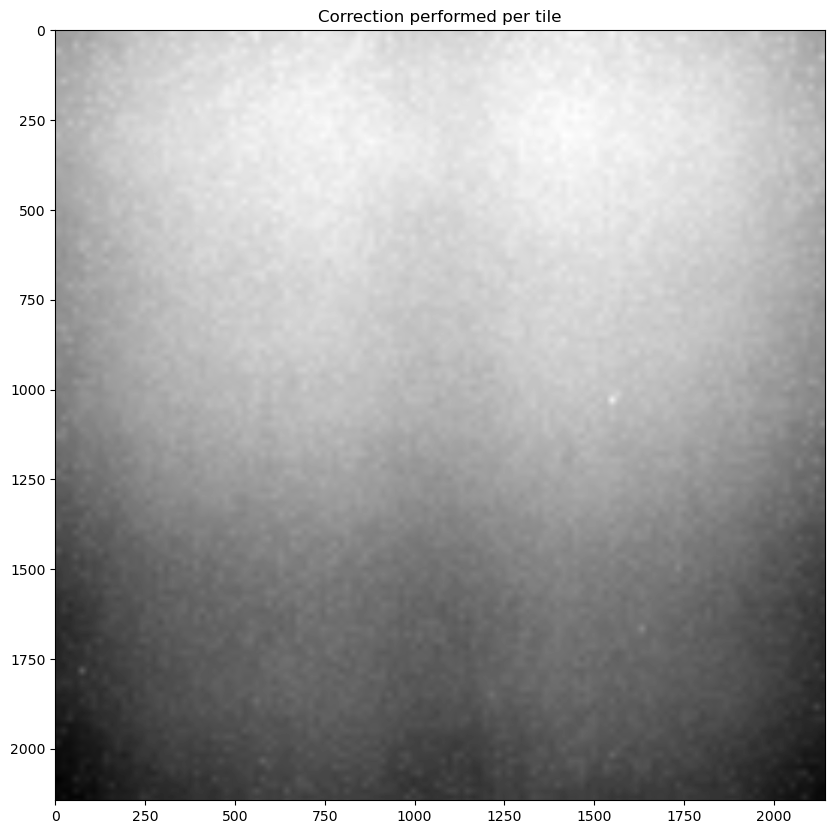

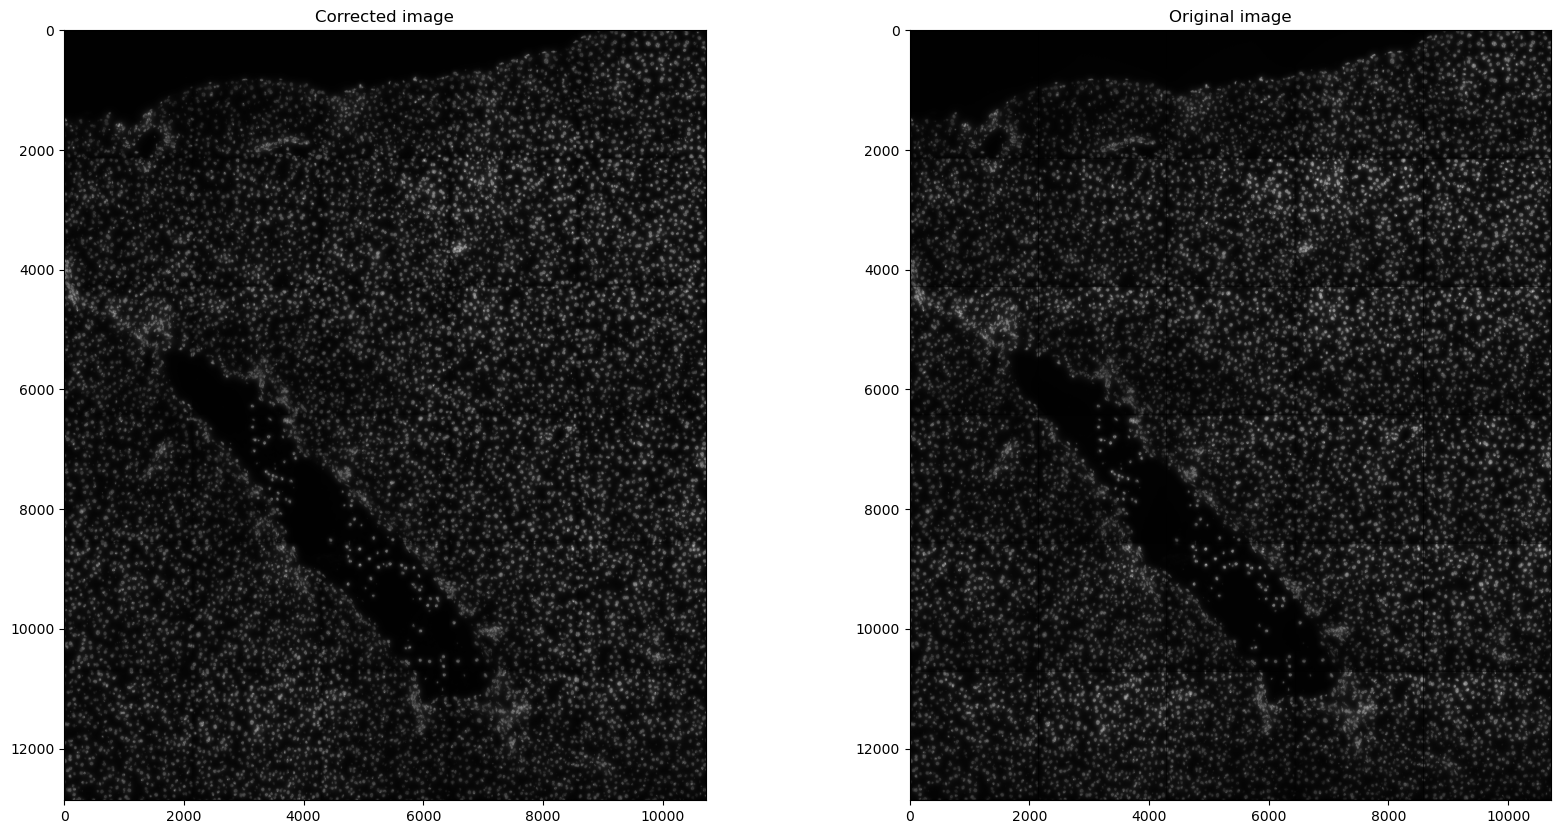

In [4]:
# Feature extraction only works for left_corner = [0, 0] due to translation of polygons and image ndarray always starting from 0
ic_correct, flatfield = fc.tilingCorrection(
    img=ic,
    left_corner=[0, 0] if SMALL_IMAGE else None,
    size=[2144, 2144] if SMALL_IMAGE else None,
)
fc.tilingCorrectionPlot(ic_correct.data.image.squeeze().to_numpy(), flatfield, img)

11.972874641418457


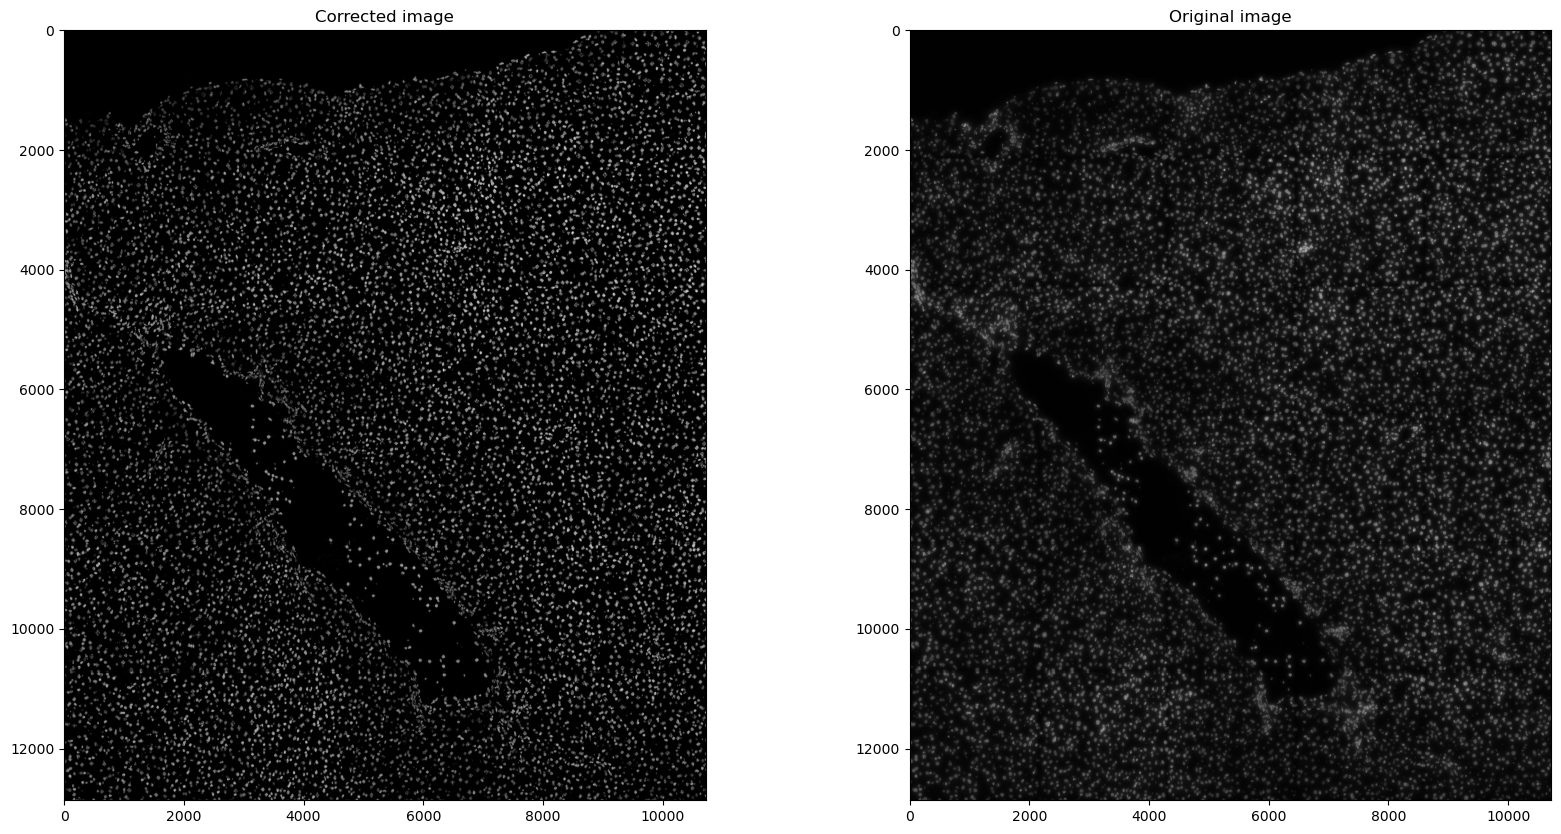

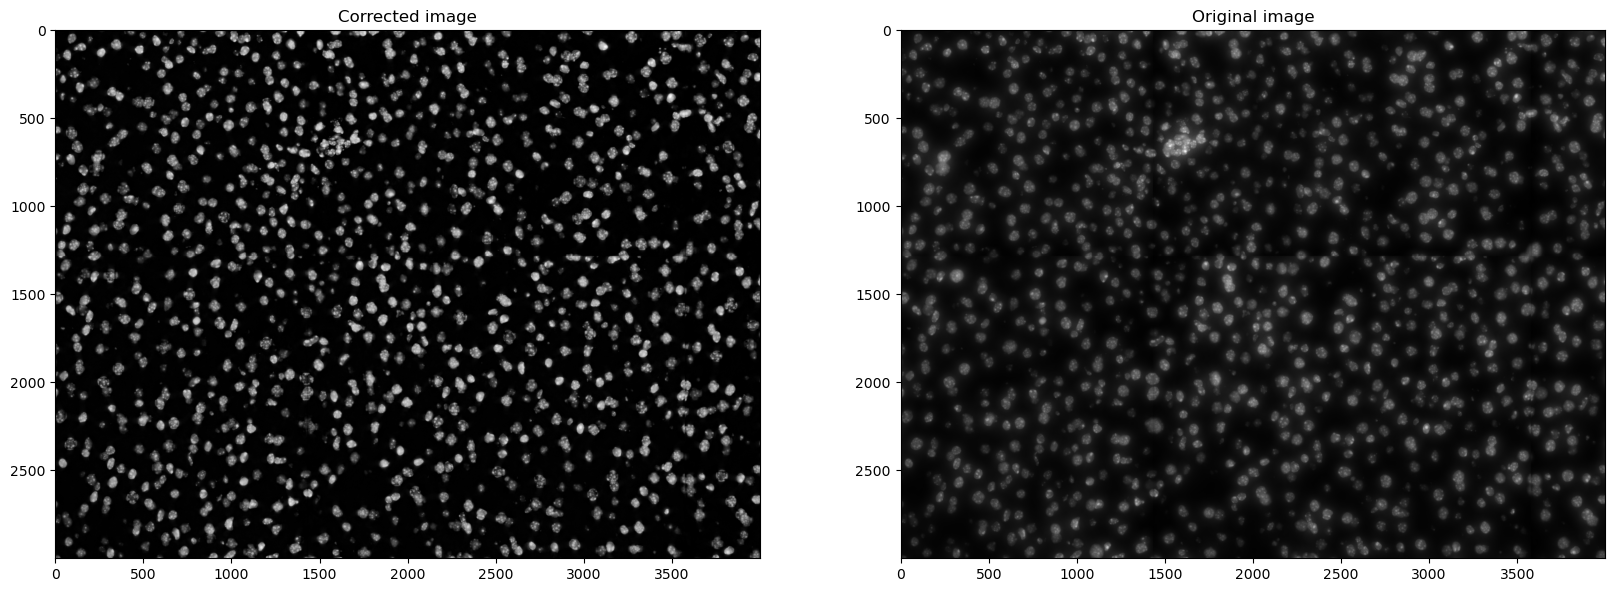

In [5]:
crd = [3000, 6000, 5000, 9000]  # a small subset of interest for visualization purposes.

if SMALL_IMAGE:
    # Smaller crd for demo purposes
    crd = [2000, 4000, 2000, 4000]
t0 = time.time()
ic_preproces = fc.preprocessImage(img=ic_correct, size_tophat=45, contrast_clip=3.5)
print(time.time() - t0)
fc.preprocessImagePlot(
    ic_preproces.data.image.squeeze().to_numpy(),
    ic_correct.data.image.squeeze().to_numpy(),
    small_size_vis=crd,
)

185.16687488555908


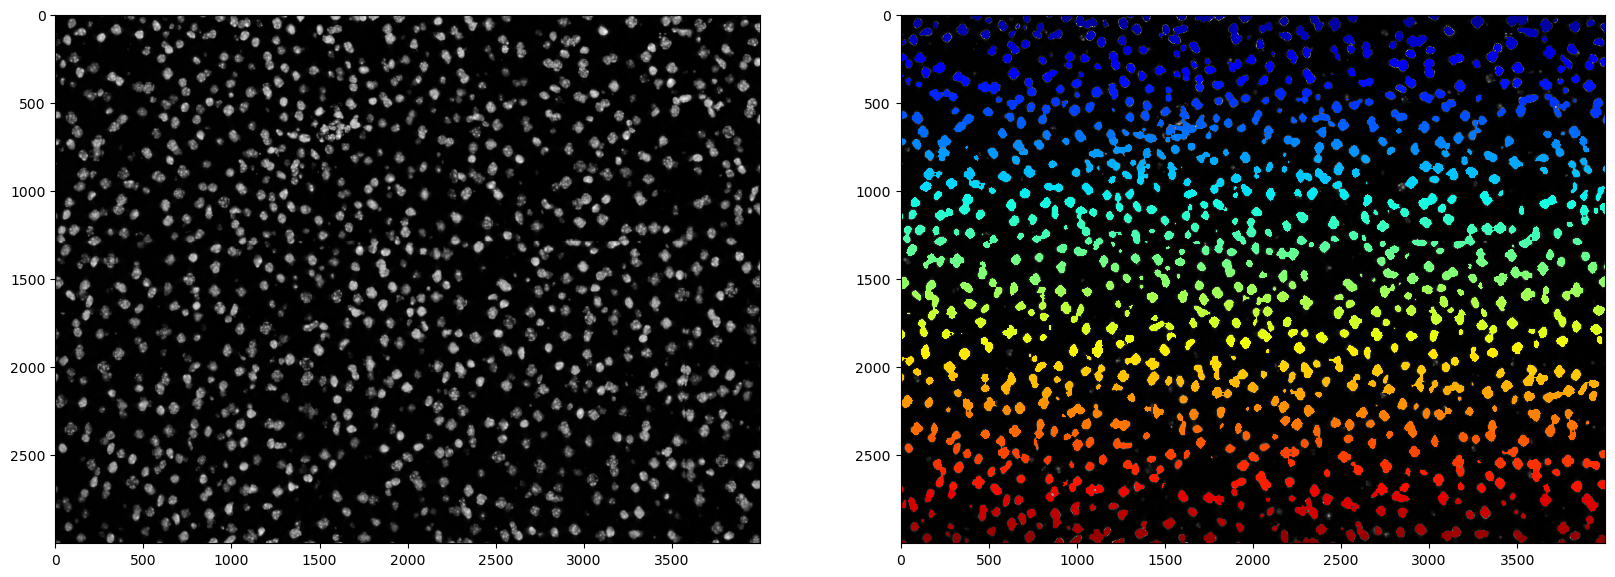

In [6]:
img_preproces = ic_preproces.data.image.squeeze().to_numpy()
t0 = time.time()
masks, mask_i, polygons, img = fc.segmentation(
    ic_preproces,
    device=DEVICE,
    cellprob_threshold=-4,
    flow_threshold=0.9,
    diameter=50,
    model_type="nuclei",
)
print(time.time() - t0)
fc.segmentationPlot(img_preproces, mask_i, polygons, small_size_vis=crd)

/srv/scratch/koends/napari-sparrow/src/napari_sparrow/functions.py:400: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(cell_counts[cell_counts.index != 0])
/srv/scratch/koends/anaconda3/envs/napari-sparrow/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/srv/scratch/koends/napari-sparrow/src/napari_sparrow/functions.py:423: FutureWarning: X.dtype being converted to np.float32 from object. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata.uns["spatial"][library_id]["points"] = AnnData(in_df.value

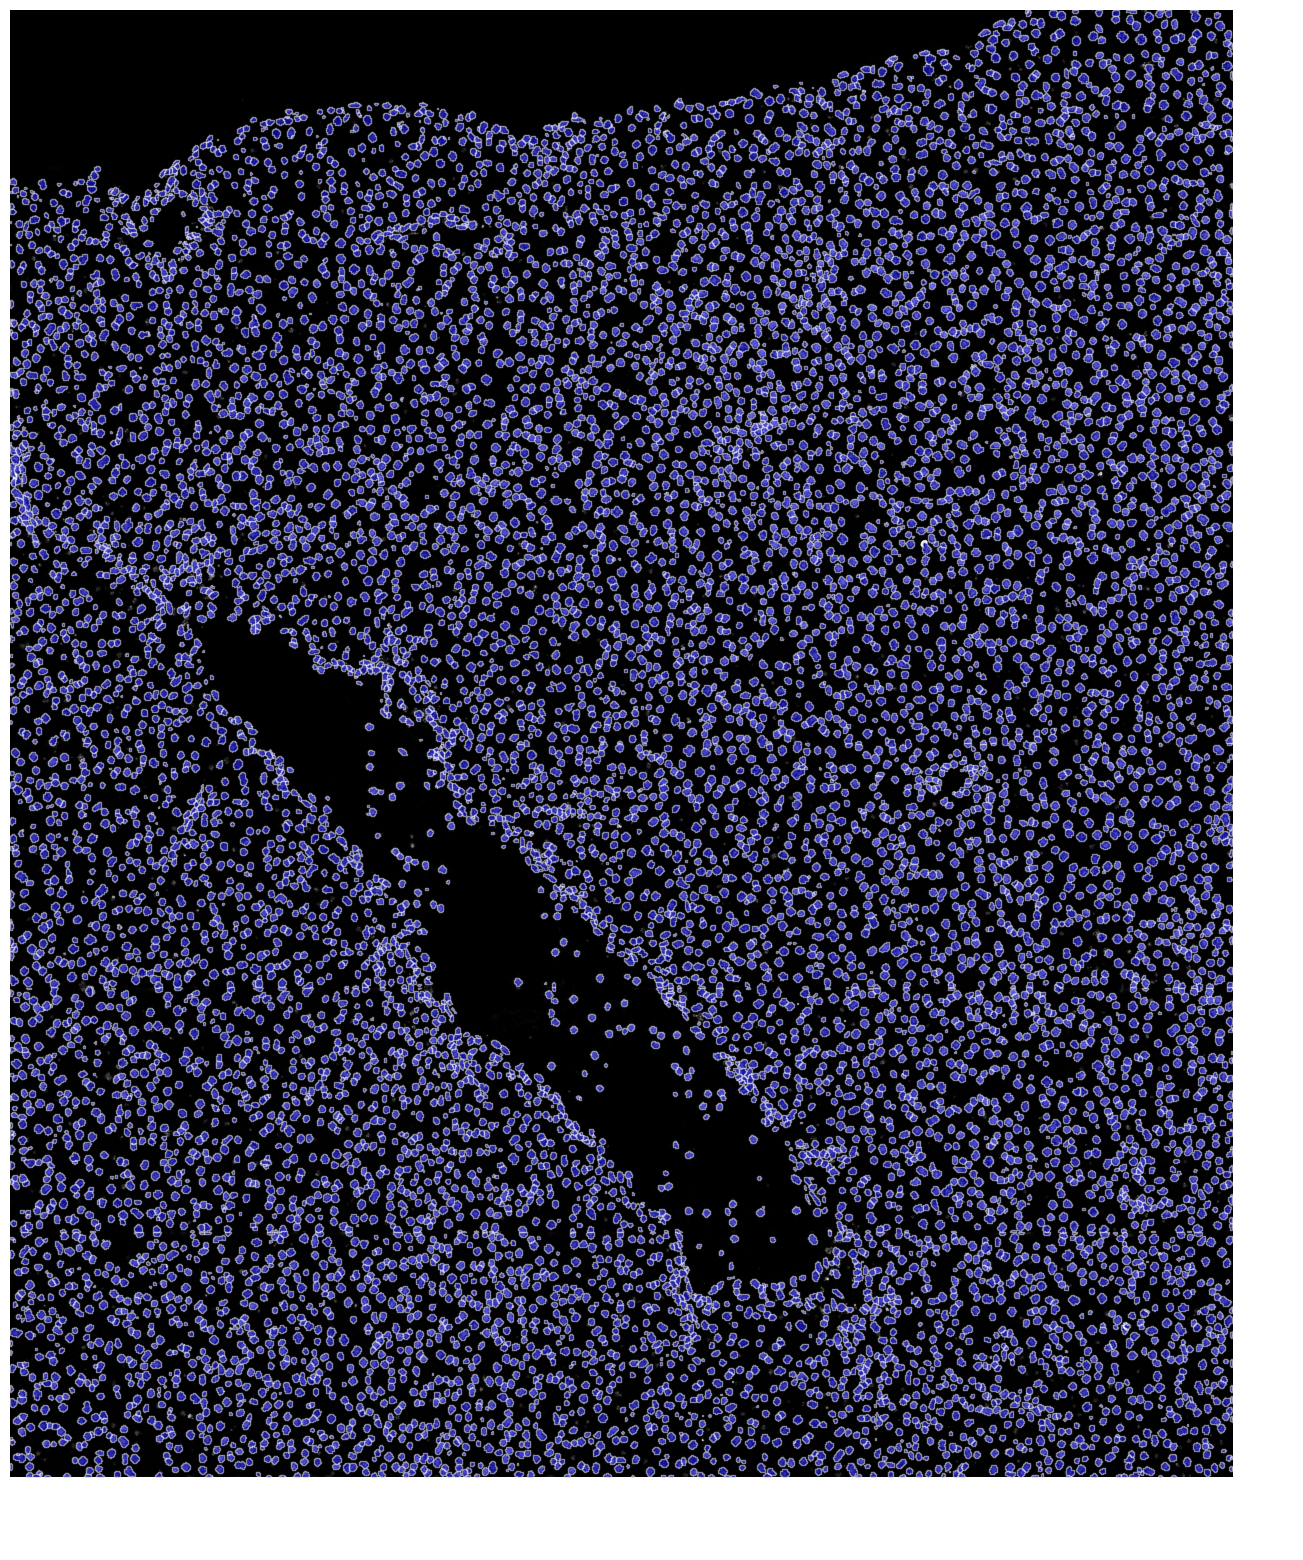

In [7]:
adata = fc.create_adata_quick(path_coordinates, ic_preproces, masks)
fc.plot_shapes(adata)

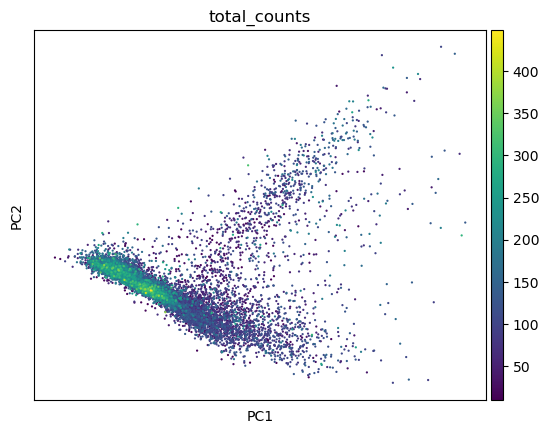

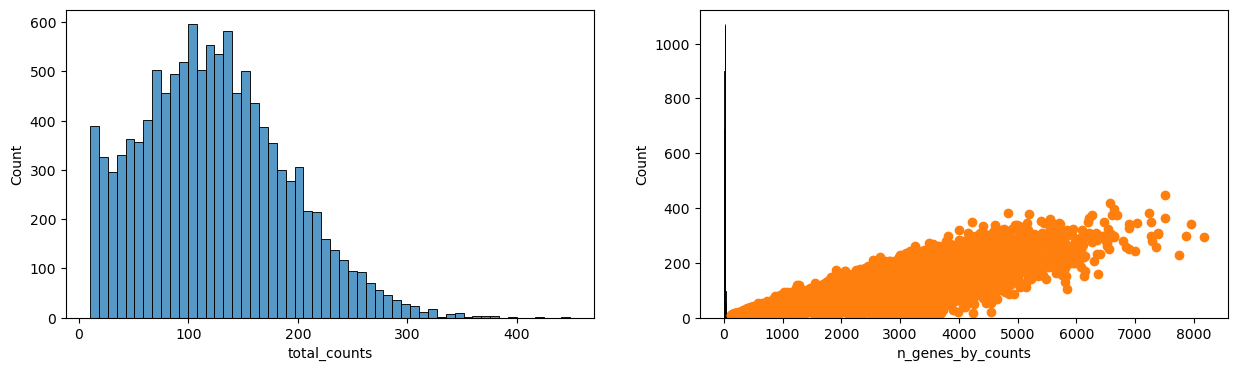

In [8]:
adata, adata_orig = fc.preprocessAdata(adata, masks)
fc.preprocesAdataPlot(adata, adata_orig)

In [9]:
adata, filtered = fc.filter_on_size(adata, min_size=500)
print(str(filtered) + " cells were filtered out based on size.")

284 cells were filtered out based on size.


/srv/scratch/koends/napari-sparrow/src/napari_sparrow/functions.py:589: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata.obsm["polygons"] = geopandas.GeoDataFrame(


In [10]:
import matplotlib.pyplot as plt

new_adata = fc.extract(img, adata)
print(adata.uns["spatial"])
print(adata)
new_adata.obsm["segmentation_features"].head()

  0%|          | 0/11293 [00:00<?, ?/s]

{'melanoma': {'images': {'hires': array([[ 49,  49,  49, ..., 367, 363, 358],
       [ 45,  49,  54, ..., 367, 363, 358],
       [ 45,  45,  45, ..., 367, 363, 358],
       ...,
       [ 61,  61,  61, ..., 165, 165, 170],
       [ 70,  70,  70, ..., 165, 165, 170],
       [ 70,  70,  74, ..., 165, 165, 170]], dtype=uint16)}, 'scalefactors': {'tissue_hires_scalef': 1, 'spot_diameter_fullres': 75}, 'segmentation': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16), 'points': AnnData object with n_obs × n_vars = 4754932 × 2
    obs: 'gene'}}
AnnData object with n_obs × n_vars = 11293 × 99
    obs: 'cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_2_genes', 'pct_counts_in_top_5_genes', 'n_counts', 'nucleusSize', 'distance'
    var: 'n_cells_by_counts', 'mean_c

segmentation_label  segmentation_area_mean  segmentation_area_std  \
1                   2              927.000000             401.000000   
2                   3              624.333333             553.478897   
3                   1             3665.000000               0.000000   
4                   2              624.000000             569.000000   
5                   1             2426.000000               0.000000   

   segmentation_ch-0_mean_intensity_mean  segmentation_ch-0_mean_intensity_std  
1                            4171.239704                            191.233680  
2                            2867.628325                           1824.410747  
3                            3327.949523                              0.000000  
4                            2484.990101                           1115.953738  
5                            3829.247321                              0.000000

(12864, 10720)


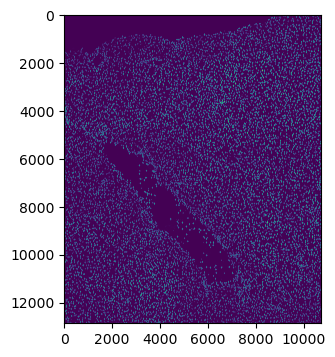

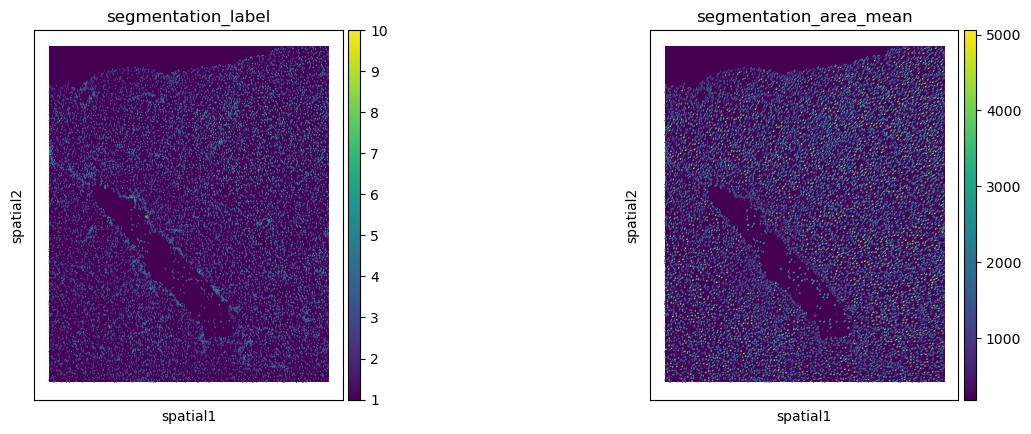

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(8, 4))
axes.imshow(adata.uns["spatial"]["melanoma"]["images"]["hires"])

print(adata.uns["spatial"]["melanoma"]["images"]["hires"].shape)
# plot segmentation features
sc.pl.spatial(
    sq.pl.extract(new_adata, "segmentation_features"),
    color=[
        "segmentation_label",
        "segmentation_area_mean",
    ],
    img=adata.uns["spatial"]["melanoma"]["images"]["hires"],
    scale_factor=adata.uns["spatial"]["melanoma"]["scalefactors"][
        "tissue_hires_scalef"
    ],
    spot_size=50,
)